<a href="https://colab.research.google.com/github/ogozcelik/neural-project/blob/main/EEE_build_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import backend as K
import datetime, os
from tensorflow.keras import layers
from tensorflow.keras import utils
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import urllib.request
from PIL import Image
import h5py
import os, sys, time
from tqdm import tqdm
import json
from nltk.translate.bleu_score import sentence_bleu
# from pyimagesearch.cancernet import CancerNet
# have your model in another file later

In [39]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
main_dir = '/content/drive/MyDrive/EEE443/project/EEE443'
test_im_dir = os.path.join(main_dir, 'images_test/test_images')

In [5]:
# for test_cap.txt (test_cap_ids) use np.arange(len(test_cap))
with h5py.File(os.path.join(main_dir,'eee443_project_dataset_test.h5'), 'r') as f:
  # List all groups
  print("Keys: %s" % f.keys())
  # get the data
  test_cap = np.array(list(f[list(f.keys())[0]]))  # captions
  # train_imid = np.array(list(f[list(f.keys())[1]])) # indices of images
  # train_ims = np.array(list(f[list(f.keys())[2]]))  # pretrained feature vector
  # train_url = np.array(list(f[list(f.keys())[3]]))  # urls to images
  # word_code = np.array(list(f[list(f.keys())[4]]))  # vocabulary

Keys: <KeysViewHDF5 ['test_caps', 'test_imid', 'test_ims', 'test_url']>


In [20]:
val_cap_ids = np.loadtxt(os.path.join(main_dir,'val_cap.txt'), dtype=int)
train_cap_ids = np.loadtxt(os.path.join(main_dir,'train_cap.txt'), dtype=int)
train_im_paths2 = np.loadtxt(os.path.join(main_dir,'train_im_paths2.txt'), dtype=str)
val_im_paths2 = np.loadtxt(os.path.join(main_dir,'val_im_paths2.txt'), dtype=str)
test_im_paths = np.loadtxt(os.path.join(main_dir,'test_im_paths.txt'), dtype=str)

In [9]:
embedding_matrix = np.load(os.path.join(main_dir, 'word_embeddings.npy'))
embedding_matrix_tf = tf.convert_to_tensor(embedding_matrix)

In [ ]:
train_one_hot = tf.one_hot(np.arange(embedding_matrix.shape[0]), depth=embedding_matrix.shape[0], axis=-1)

In [23]:
def _input_val():
  def generator():
    for im, cap in zip(tf.convert_to_tensor(val_im_paths2), tf.convert_to_tensor(train_cap[val_cap_ids])):
      feature = tf.io.read_file(im)
      feature = tf.strings.split(feature, sep='\n')
      split_tf = tf.strings.to_number(feature[:-1])
      indices = tf.convert_to_tensor(cap)
      indices = tf.reshape(indices, (indices.shape[0],1))
      encoded = tf.gather_nd(train_one_hot, indices, batch_dims=0)
      yield ({"feature_input": split_tf}, encoded)

  dataset = tf.data.Dataset.from_generator(generator, output_types=({"feature_input": tf.float16}, tf.float16))
  dataset = dataset.shuffle(val_im_paths2.shape[0])
  dataset = dataset.batch(BATCH_SIZE)
  return dataset

In [25]:
def _input_train():
  def generator():
    for im, cap in zip(tf.convert_to_tensor(train_im_paths2), tf.convert_to_tensor(train_cap[train_cap_ids])):
      feature = tf.io.read_file(im)
      feature = tf.strings.split(feature, sep='\n')
      split_tf = tf.strings.to_number(feature[:-1])
      indices = tf.convert_to_tensor(cap)
      indices = tf.reshape(indices, (indices.shape[0],1))
      encoded = tf.gather_nd(train_one_hot, indices, batch_dims=0)
      yield ({"feature_input": split_tf}, encoded)

  dataset = tf.data.Dataset.from_generator(generator, output_types=({"feature_input": tf.float16}, tf.float16))
  dataset = dataset.shuffle(train_im_paths2.shape[0])
  dataset = dataset.batch(BATCH_SIZE)
  return dataset

In [27]:
def _input_test():
  def generator():
    for im, cap in zip(tf.convert_to_tensor(test_im_paths2), tf.convert_to_tensor(test_cap)):
      feature = tf.io.read_file(im)
      feature = tf.strings.split(feature, sep='\n')
      split_tf = tf.strings.to_number(feature[:-1])
      indices = tf.convert_to_tensor(cap)
      indices = tf.reshape(indices, (indices.shape[0],1))
      encoded = tf.gather_nd(train_one_hot, indices, batch_dims=0)
      yield ({"feature_input": split_tf}, encoded)

  dataset = tf.data.Dataset.from_generator(generator, output_types=({"feature_input": tf.float16}, tf.float16))
  dataset = dataset.shuffle(train_im_paths2.shape[0])
  dataset = dataset.batch(BATCH_SIZE)
  return dataset

In [12]:
# All the hyperparameters here
VAL_SPLIT = 0.15
BATCH_SIZE = 16
OPT = keras.optimizers.Adam(0.00001) # optimizer
EARLY_STOPPING_PATIENCE = 3 
MAX_EPOCHS = 40
from tensorflow.keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=EARLY_STOPPING_PATIENCE, mode="auto", verbose=1)

In [28]:
train_dataset = _input_train().apply(tf.data.experimental.ignore_errors(log_warning=True))
val_dataset = _input_val().apply(tf.data.experimental.ignore_errors(log_warning=True))
test_dataset = _input_test().apply(tf.data.experimental.ignore_errors(log_warning=True))

In [16]:
def step(X, y):
  # keep track of our gradients
  with tf.GradientTape() as tape:
    # make a prediction using the model and then calculate the
    # loss
    pred = model(X)
    loss = keras.losses.categorical_crossentropy(y, pred)
  # calculate the gradients using our tape and then update the
  # model weights
  grads = tape.gradient(loss, model.trainable_variables)
  OPT.apply_gradients(zip(grads, model.trainable_variables))
  return tf.math.reduce_mean(loss)

In [13]:
def build_model():
  vocabulary_size = embedding_matrix.shape[0]
  feature_input = layers.Input(shape=(2048,), name='feature_input')
  encoder = layers.Dense(2048, activation='relu', name='encoder')(feature_input)
  repeat = layers.RepeatVector(17, name='repeat')(encoder)
  lstm1 = layers.LSTM(1024, return_sequences=True, name='lstm1')(repeat)
  dropout1 = layers.Dropout(0.2)(lstm1)
  lstm2 = layers.LSTM(1024, return_sequences=True, name='lstm2')(dropout1)
  dropout2 = layers.Dropout(0.1)(lstm2)
  lstm3 = layers.LSTM(vocabulary_size, return_sequences=True, name='lstm3')(dropout2)
  dense = layers.Dense(vocabulary_size, activation='relu')(lstm3)
  softmax = layers.Activation('softmax', name='softmax')(dense)
  model = keras.Model(inputs=feature_input, outputs=softmax, name='model')
  model.compile(loss='categorical_crossentropy', optimizer = OPT, metrics=['accuracy'])
  return model

In [14]:
model = build_model()

In [60]:
def train():
  OPT = keras.optimizers.Adam(0.00001) # optimizer
  up_count = EARLY_STOPPING_PATIENCE
  prev_val_loss = 100
  metrics = {'train_hist':[], 'val_hist':[]}
  for epoch in range(MAX_EPOCHS):
    print("[INFO] starting epoch {}/{}...".format(epoch + 1, MAX_EPOCHS), end="")
    sys.stdout.flush()
    epochStart = time.time()
    for i, (x, y) in enumerate(train_dataset):
      train_loss = step(x,y)
    
    val_loss, val_acc = test(val_dataset)
    if val_loss > prev_val_loss:
      up_count -= 1
    else:
      up_count = EARLY_STOPPING_PATIENCE
    prev_val_loss = val_loss

    metrics['train_hist'].append(train_loss)
    metrics['val_hist'].append(val_loss)
    metrics['val_acc'].append(val_acc)
    epochEnd = time.time()
    elapsed = (epochEnd - epochStart) / 60.0
    print("Epoch {} => {:.4} minutes => train_loss: {}, val_loss: {}, val_acc: {}".format(epoch, elapsed, train_loss, val_loss, val_acc))
    epoch_dir = os.path.join(main_dir, 'epoch_' + epoch)
    os.mkdir(epoch_dir)
    model.save(os.path.join(epoch_dir, 'model.h5'))
    with open(os.path.join(epoch_dir, 'metrics.txt'), 'w') as file:
      json.dump(metrics, file)
    if up_count <= 0:
      break

In [59]:
def test(dataset):
  for i, (x, y) in enumerate(dataset):
    loss = 0.0
    bleu = 0
    with tf.GradientTape() as tape:
      pred = model(x)
      loss += keras.losses.categorical_crossentropy(y, pred)
      preds = np.array([np.array([np.argmax(cap) for cap in row]) for row in pred])
      d = np.array([np.array([np.argmax(cap) for cap in row]) for row in d]).reshape((d.shape[0], 1, d.shape[1]))
      bleu += np.mean(np.array([sentence_bleu((d[j]), preds[j]) for j in range(d.shape[0])]))
  return tf.math.reduce_mean(loss), tf.math.reduce_mean(bleu)

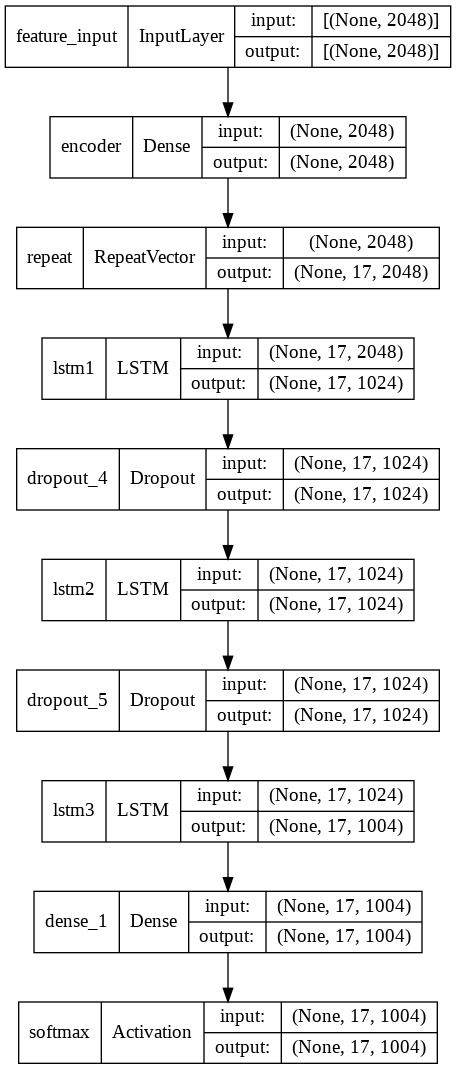

In [15]:
plot_model(model, show_shapes=True, to_file='/content/model.png')

In [ ]:
# Visualize all the layer outputs of the inception resnet with one image
layer_outputs50 = [layer.output for layer in resnet50.layers] 
activation_model50 = keras.models.Model(inputs=resnet50.input, outputs=layer_outputs50)
test_img = np.array(img) # load oneo image from the train set
if device_name == '/device:GPU:0':
  with tf.device('/device:GPU:0'):
    activations = activation_model50.predict(tf.convert_to_tensor([test_img])) 
else:
  with tf.device('/device:CPU:0'):
    print('No GPU found')
    exit()

Layer:  conv2d_203


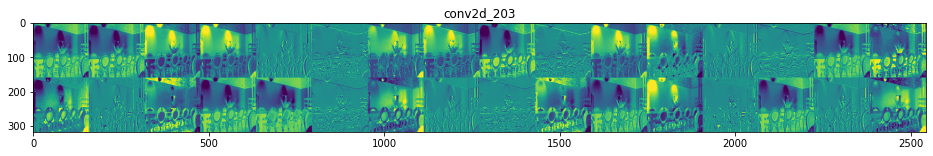

In [ ]:
layer_name = inc_resnet.layers[1].name
layer_activation = activations[1]
print('Layer: ', layer_name)
n_features = layer_activation.shape[-1] # Number of features in the feature map
size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
display_grid = np.zeros((size * n_cols, images_per_row * size))
for col in range(n_cols): # Tiles each filter into a big horizontal grid
    for row in range(images_per_row):
        channel_image = layer_activation[0, :, :, col * images_per_row + row]
        channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, # Displays the grid
                      row * size : (row + 1) * size] = channel_image
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')
# choose until which layer you want to take